# One-Dimensional Climate Models: Brown Dwarfs w/ Clouds

In this tutorial you will learn how to run 1-D climate models for brown dwarfs with Virga clouds included self-consistently! 

You should already be familiar with running 1-D climate models with running a [simple clear brown dwarf model](https://natashabatalha.github.io/picaso/notebooks/climate/12a_BrownDwarf.html)

What you need to have downloaded for clouds to work: 
[Virga](https://natashabatalha.github.io/virga/installation.html)


In [1]:
import warnings
warnings.filterwarnings('ignore')
import picaso.justdoit as jdi
import picaso.justplotit as jpi
import virga.justdoit as vj
import virga.justplotit as cldplt
jpi.output_notebook()
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import xarray
from bokeh.plotting import show, figure

Loading BokehJS ...

In [ ]:
#1 ck tables from roxana
mh = '+000'#'+0.0' #log metallicity
CtoO = '100'#'1.0' # CtoO ratio

ck_db = f'/data/kcoeff_2020_v3/sonora_2020_feh{mh}_co_{CtoO}.data.196'
#sonora bobcat cloud free structures file
sonora_profile_db = '/data/sonora_bobcat/structure/structures_m+0.0'

In [3]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

In [4]:
nlevel = 91 # number of plane-parallel levels in your code

pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)

In [5]:
nofczns = 1 # number of convective zones initially

# for the sake of time in this tutorial, I set it to a higher layer because I know where it should be in this case. 
# In general for clouds it is better to start deeper in the atmosphere and work your way up. It just takes a lot more time unfortunately.
nstr_upper = 52 # top most level of guessed convective zone 

nstr_deep = nlevel - 2 # this is always the case. Dont change this

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

If you are unfamiliar with Virga, we highly recommend going through the [tutorials](https://natashabatalha.github.io/virga/tutorials.html) to understand the basics of how we generate those clouds before pairing them with the 1-D climate models here. It is also necessarry to have the mieff files generated for the cloud species you want to include.

**New PICASO code parameters**: 

1. `cloudy=True` : (True/False) Turns on clouds
2. `species` : (list) Desired cloud species, this can be multiple cloud species as well
3. `fsed` : (float) Sedimenation efficiency parameter.
4. `mieff_dir` :  (str) directory where Mie optical property files are stored from virga

**Optional arguments**:
1. `cold_trap` : (bool) Default = False. Restricts the abundance of condensing cloud species from increasing in the layers above where the cloud begins to condense.
2. `virga_param` : 'const' or 'exp', default = 'const' but you can experiment with 'exp' to follow the cloud prescription described in [Rooney et al. 2022](https://ui.adsabs.harvard.edu/abs/2022ApJ...925...33R/abstract)
3. `beta` : (float) beta value in eq. 12 of Rooney et al. 2022 see [this notebook](https://natashabatalha.github.io/virga/notebooks/6_Variable_fsed.html) for more details about variable fseds

In [6]:
virga_dir = '/Users/jjm6243/Documents/virga/' # path to virga directory with the Mie scatering files

In [7]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, mh = '0.0', CtoO = '1.0', 
                      cloudy = True, species = ['H2O'], fsed = 8.0, mieff_dir = virga_dir, cold_trap = True)

Cloudy functionality still in beta form and not ready for public use.


In [8]:
out = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  76.90400060888983 1201.626958508664 , flux balance  0.36551412976184094
Iteration number  1 , min , max temp  78.74120431832056 1201.541155742957 , flux balance  0.36292418135967003
Iteration number  2 , min , max temp  80.4611673238956 1201.44762126377 , flux balance  0.36011234087158117
Iteration number  3 , min , max temp  82.13659638800713 1201.3456885038981 , flux balance  0.3570616628099861
Iteration number  4 , min , max temp  83.76444723111898 1201.234580645464 , flux balance  0.3537525657314842
Iteration number  5 , min , max temp  85.34352268157477 1201.1133915971138 , flux balance  0.35016243795937463
Iteration number  6 , min , max temp  86.87453984112699 1200.9810739408497 , flux balance  0.34626549759921266
Iteration number  7 , min , max temp  88.32554883358226 1200.836430399755 , flux balance  0.34203280747010917
Iteration number  8 , min , max temp  89.72990416914324 1200.6781176945187 , flux balance  0.33743270675758325
Iteration 

## Plot the P-T Profile

Before we plot the PT profile of the model, we want to grab the condensation curve for H2O just to help us visualize where in the atmosphere we expect the cloud to start forming. To the left of this condensation curve is where we expect the H2O vapour to condense into a cloud.

In [9]:
h2o_cond_p, h2o_cond_t = vj.condensation_t('H2O', 1, 2.2, pressure = out['pressure'])

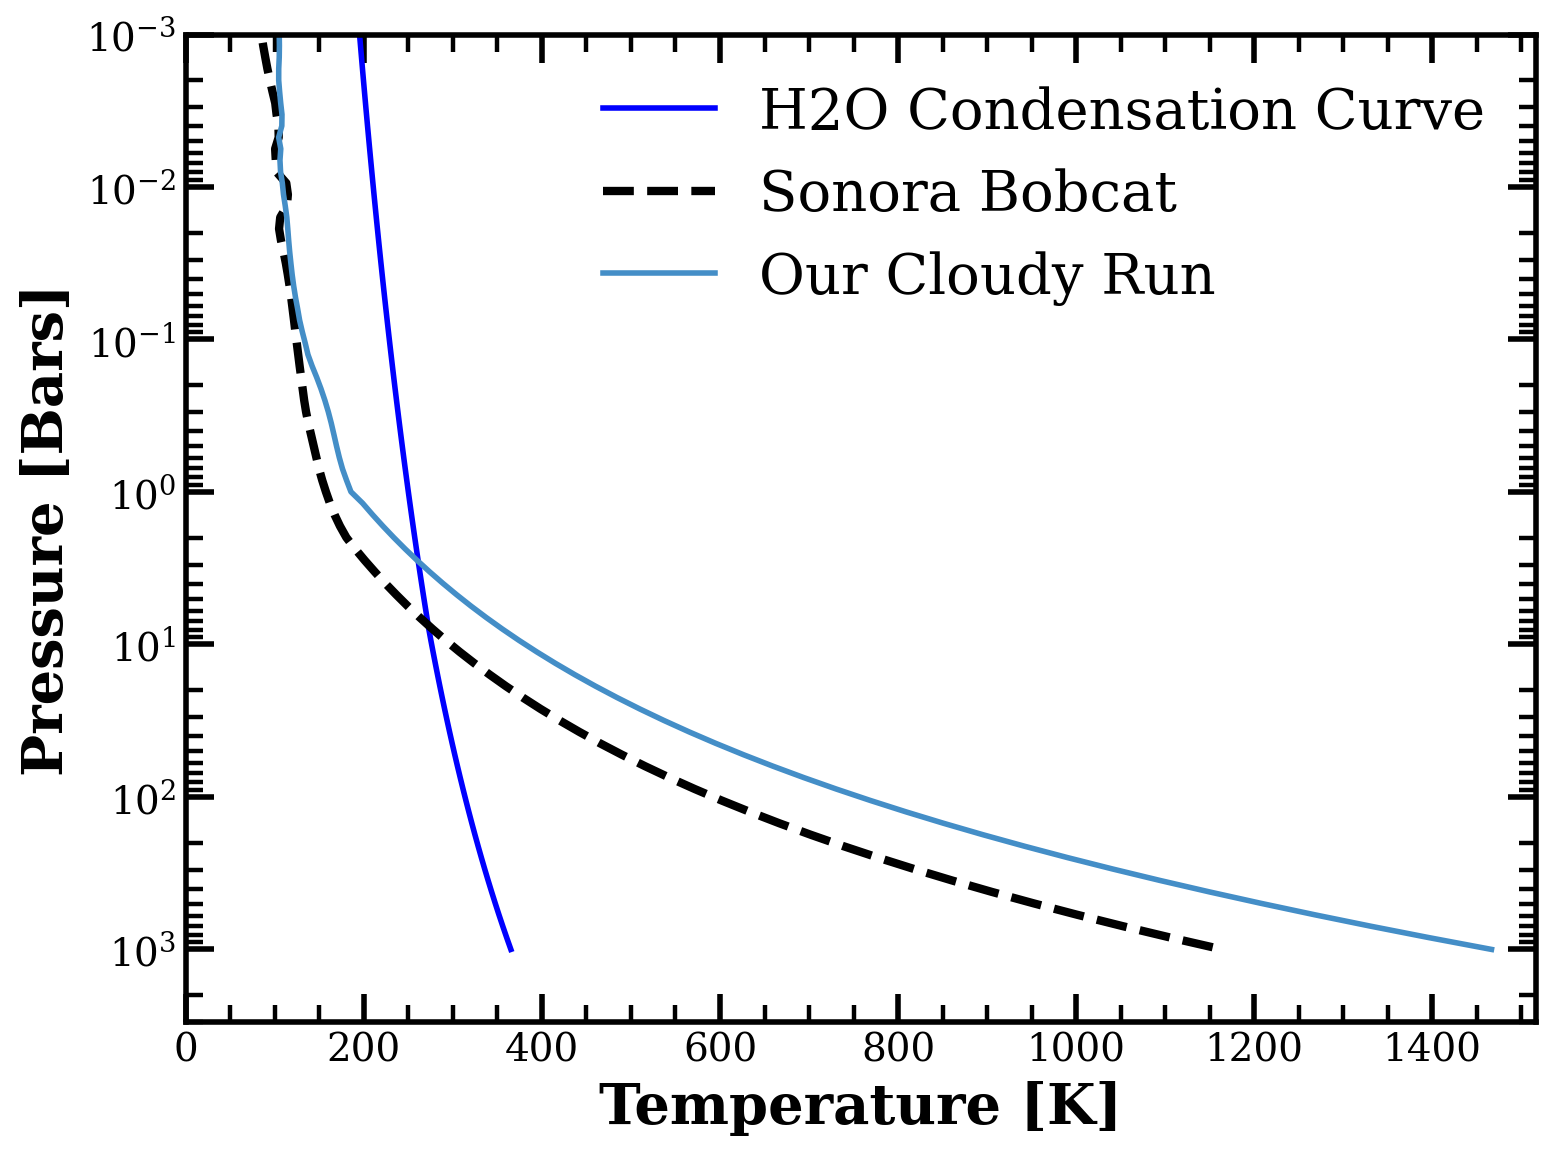

In [10]:
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.plot(h2o_cond_t,h2o_cond_p, 'b', label = 'H2O Condensation Curve')
plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")

plt.semilogy(out['temperature'],out['pressure'],label="Our Cloudy Run")

plt.legend()
plt.tight_layout()
plt.show()

Now you should be able to see a mostly smooth PT profile that's a little warmer than the cloud-free Sonora Bobcat profile. Even though it looks warmer, the actual effective temperature of the object is the same because the water cloud opacity blocks out some of the flux. 

As you may know (or will find out) clouds are really difficult to converge models for especially with H2O clouds in cold regions for example. To learn more about common signs that you should look for to identify "bad" models, take a look at the [Diagnostics notebook]()

## Looking at the Cloud Properties

If you look at the climate output now, you will notice a couple of new keys in the dictionary that helps you look at the cloud properties

In [11]:
out.keys()

dict_keys(['pressure', 'temperature', 'ptchem_df', 'dtdp', 'cvz_locs', 'flux', 'fnet/fnetir', 'converged', 'cld_output_picaso', 'virga_output', 'cld_output_final', 'all_profiles', 'all_opd', 'spectrum_output'])

`cld_output_picaso` and `virga_output` are the two important dictionary key outputs for cloudy runs. `cld_output_picaso` is in the format to be used to generate spectra.

In [12]:
out['cld_output_picaso']

,opd,w0,g0,pressure,wavenumber
0,0.0,0.0,0.0,0.000195,37313.432836
1,0.0,0.0,0.0,0.000195,34843.205575
2,0.0,0.0,0.0,0.000195,32051.282051
3,0.0,0.0,0.0,0.000195,29673.590504
4,0.0,0.0,0.0,0.000195,27624.309392
...,...,...,...,...,...
17635,0.0,0.0,0.0,918.620000,185.601069
17636,0.0,0.0,0.0,918.620000,135.699940
17637,0.0,0.0,0.0,918.620000,102.299697
17638,0.0,0.0,0.0,918.620000,72.049743


`virga_output` can then be directly used with virga functions to easily visualize the properties as well. For more details about these individual properties and how to interpret them, please take a look at the [Analyzing Your Runs](https://natashabatalha.github.io/virga/notebooks/3_AnalyzingRuns.html) virga tutorial.

In [13]:
show(cldplt.all_optics_1d(out['virga_output'], wave_range=[1,2]))

In [14]:
show(cldplt.all_optics(out['virga_output']))

In [15]:
show(cldplt.opd_by_gas(out['virga_output']))

In [16]:
show(cldplt.condensate_mmr(out['virga_output']))

## Cloudy vs Clear Spectra

Now we can generate the spectrum for the cloudy run. This is exactly like how we generate any other thermal emission spectrum except this time we add in the cloud profile. (You may have done this before if you've tried to use a post-processed virga cloud)

In [17]:
opa_mon = jdi.opannection(wave_range=[0.3,15])

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out['ptchem_df'])

# now let's add the cloud optical properties
hi_res.clouds(df=out['cld_output_picaso'])

df_spec = hi_res.spectrum(opa_mon, calculation='thermal',full_output=True)

wno, fp = df_spec['wavenumber'], df_spec['thermal'] #erg/cm2/s/cm
xmicron = 1e4/wno

flamy = fp*1e-8  # per anstrom instead of per cm
sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                           waveunits='um',
                           fluxunits='FLAM')
sp.convert("um")
sp.convert('Fnu')  # erg/cm2/s/Hz

wno = sp.wave  # micron
fp = sp.flux  # erg/cm2/s/Hz
df_spec['fluxnu'] = fp
wno,fp = jdi.mean_regrid(1e4/wno,fp, R =200)

In [18]:
jpi.show(jpi.spectrum(wno,fp,x_axis_type='log',y_axis_type='log'))

Now let's load in a Sonora Bobcat spectrum to compare what it looks like. This specific case has been included in this directory for ease of access but to compare other temperatures you will have to download the full [Sonora Bobcat](https://zenodo.org/records/5063476) set of models

In [ ]:
teff = 200
grav = 1000

wave_bobcat,flux_bobcat = np.loadtxt(f"sp_t200g1000nc_m0.0",
                            usecols=[0,1],unpack=True, skiprows = 2)

In [20]:
# now let's regrid the spectra to R=200 to make sure the two spectra are on the same grid
wno_bobcat, fp_bobcat = jdi.mean_regrid(1e4/wave_bobcat,flux_bobcat,R=200)

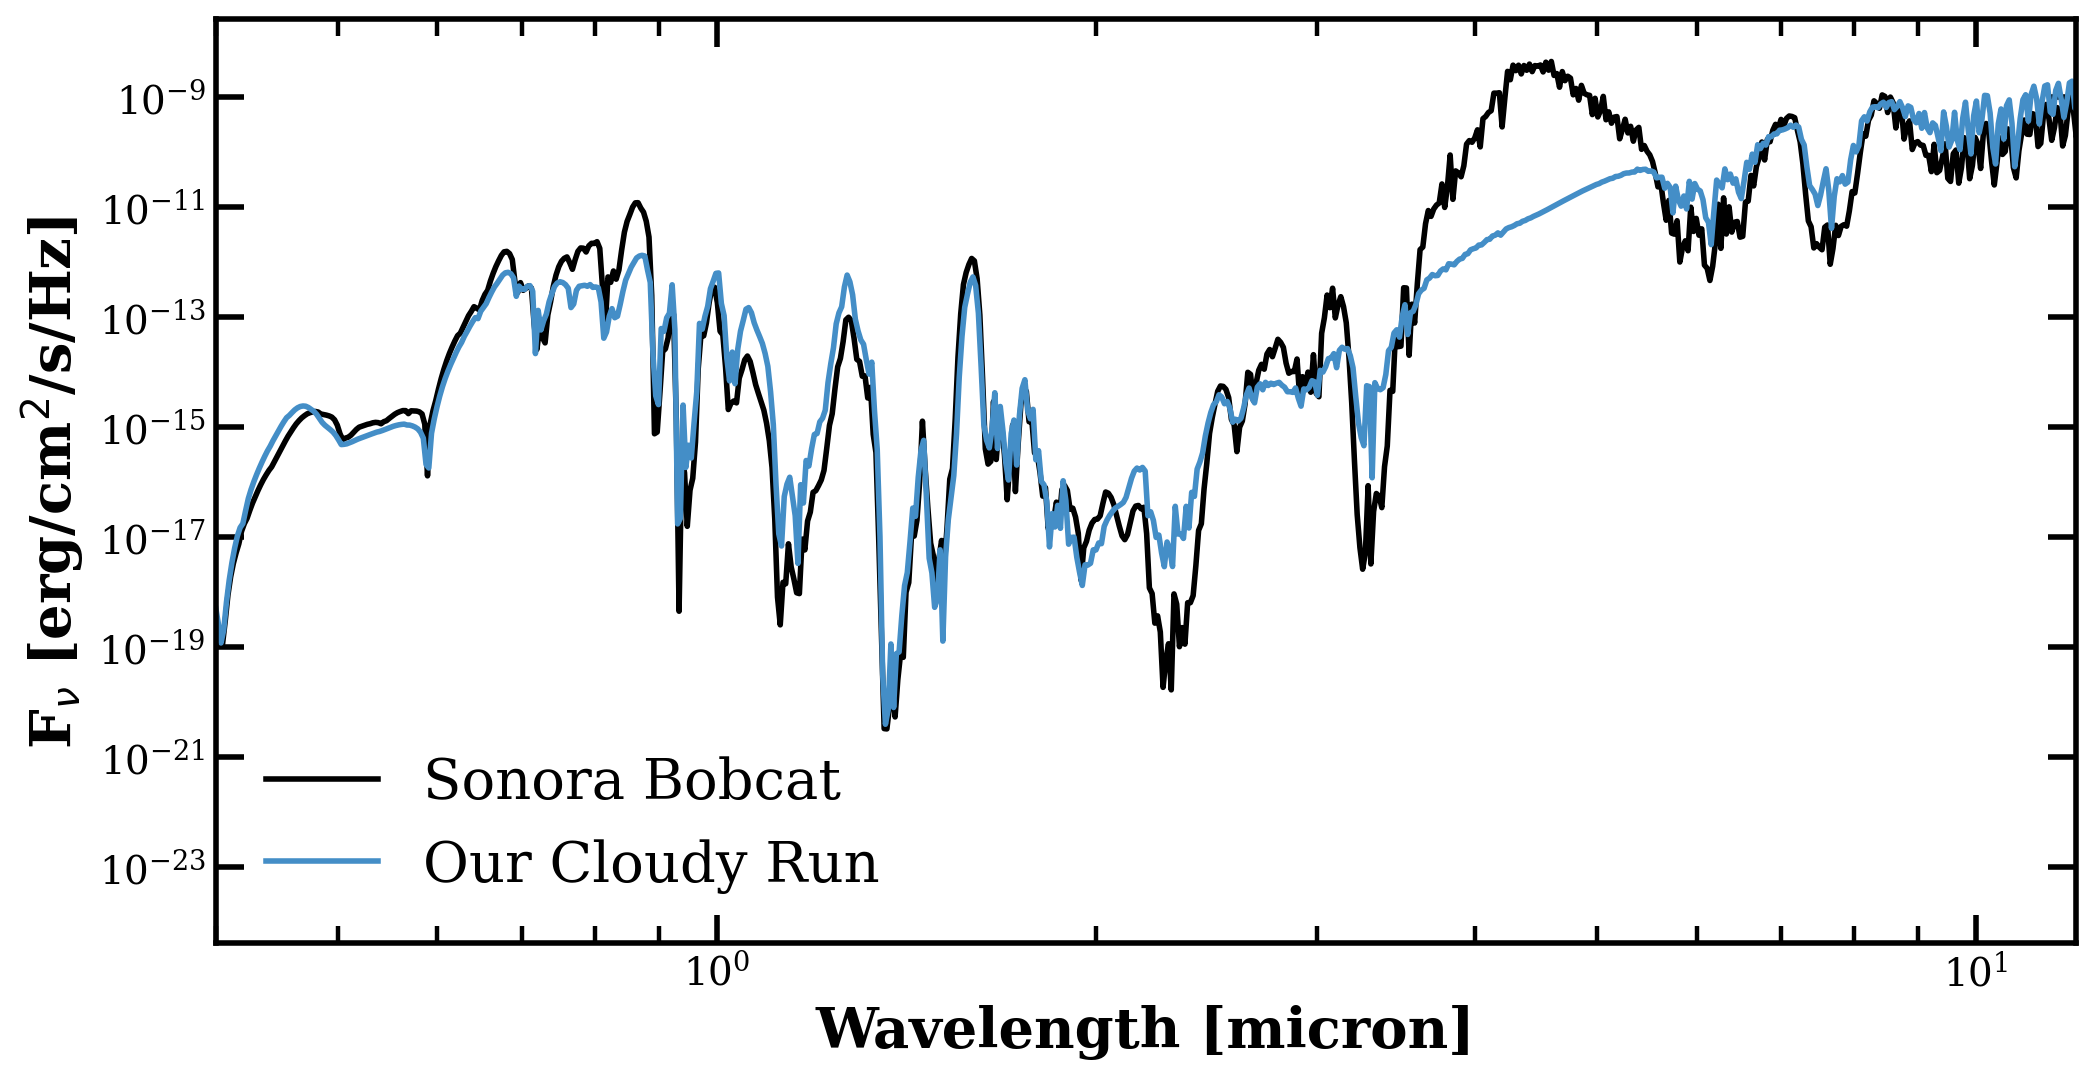

In [21]:
fig = plt.figure(figsize=(12,6))
plt.loglog(1e4/wno_bobcat,fp_bobcat, 'k', label = 'Sonora Bobcat')
plt.loglog(1e4/wno,fp, label = 'Our Cloudy Run')
plt.xlabel('Wavelength [micron]')
plt.ylabel('F$_\\nu$ [erg/cm$^2$/s/Hz]')
plt.xlim(0.4,12)
plt.legend()
plt.show()

So here you can see the large water cloud feature aroun 4-5 micron where the flux from this brown dwarf is being surpressed by the large water cloud opacity

## Patchy Clouds

Clouds are hard...Sometimes they don't behave nicely with static 1-D climate models. To alleviate this or to represent the reality that clouds may not be uniformly covering the entire atmosphere, where we see variability in brown dwarfs, we can run patchy clouds! For more on this, you can  read [Morley et al. 2014a](https://ui.adsabs.harvard.edu/abs/2014ApJ...787...78M/abstract) and [Morley et al. 2014b](https://ui.adsabs.harvard.edu/abs/2014ApJ...789L..14M/abstract)

Here we include a few new parameters for patchy clouds
1. `do_holes` : (bool) Default = False. Turn on/off patchy clouds
2. `fhole` : (float) This is a value between 0 and 1. E.g. 0.9 represents 90% clear and 10% cloudy 
3. `fthin_cld` : (float) This is a value between 0 and 1, it allows you to make the clear column have the slightest of clouds. 0 is completely clear, 1 is completely cloudy

Typically, it's easier to think about this using just fhole and ignoring fthin_cld. Use fthin_cld only if you're trying to really model complex systems or to build an intuition about clouds!

Here we're going to initiate a new climate calculation:

In [22]:
cl_run = jdi.inputs(calculation="browndwarf", climate = True) # start a calculation

#note you need to put the climate keyword to be True in order to do so
# now you need to add these parameters to your calculation

teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s

cl_run.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity
cl_run.effective_temp(teff) # input effective temperature

opacity_ck = jdi.opannection(ck_db=ck_db) # grab your opacities

In [23]:
nofczns = 1 # number of convective zones initially

nstr_upper = 52 # top most level of guessed convective zone 
# for the sake of time of this tutorial, I set it to 60 because I know where it should be in this case. In general for clouds it is better
# to start deeper in the atmosphere and work your way up. It just takes more time.

nstr_deep = nlevel - 2 # this is always the case. Dont change this
# nstr = np.array([0,nstr_upper,nstr_deep,0,0,0]) # single convective zone

nstr = np.array([0,nstr_upper,nstr_deep,0,0,0])

# Here are some other parameters needed for the code.
rfacv = 0.0 #we are focused on a brown dwarf so let's keep this as is

We can initialize the inputs just like before except we are making do_holes = True and fhole = 0.5

In [24]:
cl_run.inputs_climate(temp_guess= temp_bobcat, pressure= pressure_bobcat,
                      nstr = nstr, nofczns = nofczns , rfacv = rfacv, mh = '0.0', CtoO = '1.0', 
                      cloudy = True, species = ['H2O'], fsed = 8.0, mieff_dir = virga_dir, 
                      do_holes = True, fhole = 0.3, fthin_cld = 0, cold_trap = True)

Cloudy functionality still in beta form and not ready for public use.


In [25]:
out_patchy = cl_run.climate(opacity_ck, save_all_profiles=True,with_spec=True)

Iteration number  0 , min , max temp  76.90401138638421 1201.6269589028284 , flux balance  0.365514141682586
Iteration number  1 , min , max temp  78.74128584536147 1201.5411555451942 , flux balance  0.3629241754019671
Iteration number  2 , min , max temp  80.46124139036039 1201.4476205562564 , flux balance  0.3601123196480911
Iteration number  3 , min , max temp  82.13657854652422 1201.3456881066504 , flux balance  0.35706165094896036
Iteration number  4 , min , max temp  83.76439083803017 1201.2345809464232 , flux balance  0.35375257467169796
Iteration number  5 , min , max temp  85.3434927416961 1201.113392064315 , flux balance  0.3501624517606961
Iteration number  6 , min , max temp  86.8744864950577 1200.981074817597 , flux balance  0.34626552334087984
Iteration number  7 , min , max temp  88.32588055149013 1200.8364324826919 , flux balance  0.3420328682161142
Iteration number  8 , min , max temp  89.73022438957756 1200.6781203832381 , flux balance  0.3374327845926152
Iteration nu

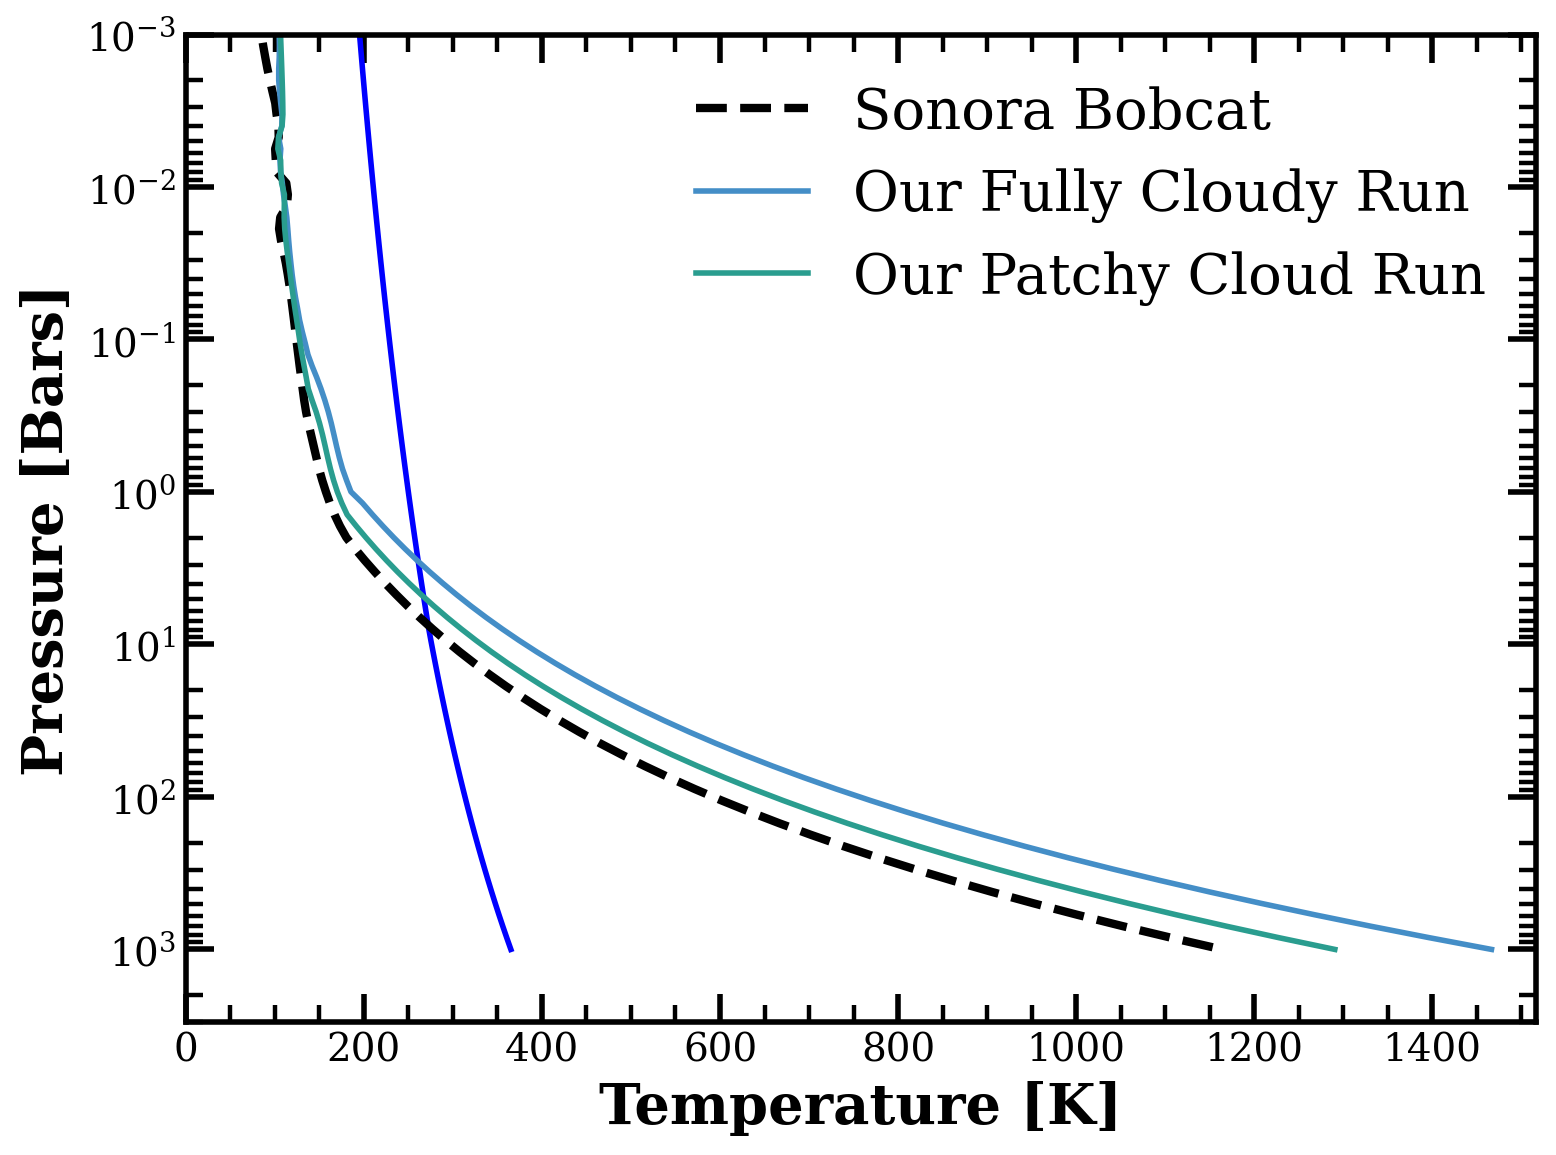

In [26]:
# now let's plot the results! 
pressure_bobcat,temp_bobcat = np.loadtxt(jdi.os.path.join(
                            sonora_profile_db,f"t{teff}g{grav}nc_m0.0.cmp.gz"),
                            usecols=[1,2],unpack=True, skiprows = 1)
plt.figure(figsize=(8,6))
plt.ylabel("Pressure [Bars]")
plt.xlabel('Temperature [K]')
plt.xlim(0,max(out['temperature'])+50)
plt.ylim(3e3,1e-3)

plt.plot(h2o_cond_t,h2o_cond_p, 'b')#, label = 'H2O Condensation Curve')
plt.semilogy(temp_bobcat,pressure_bobcat,color="k",linestyle="--",linewidth=3,label="Sonora Bobcat")

plt.semilogy(out['temperature'],out['pressure'],label="Our Fully Cloudy Run")
plt.semilogy(out_patchy['temperature'],out_patchy['pressure'],label="Our Patchy Cloud Run")

plt.legend()
plt.tight_layout()
plt.show()

What you should notice here, because the patchy clouds reduces the amount of cloud opacity in the atmosphere, the PT profile is not shifted to be warmer but is closer to the cloud-free Sonora Bobcat profile

In [27]:
opa_mon = jdi.opannection(wave_range=[0.3,15])

hi_res = jdi.inputs(calculation="browndwarf") # start a calculation
teff= 200 # Effective Temperature of your Brown Dwarf in K
grav = 1000 # Gravity of your brown dwarf in m/s/s
hi_res.gravity(gravity=grav, gravity_unit=u.Unit('m/(s**2)')) # input gravity

hi_res.atmosphere(df=out_patchy['ptchem_df'])

# now let's add the cloud optical properties, this time with arguments to make sure we take into consideration the patchy cloud parameters
hi_res.clouds(df=out_patchy['cld_output_picaso'], do_holes=True, fhole = 0.3, fthin_cld=0)

df_spec = hi_res.spectrum(opa_mon, calculation='thermal',full_output=True)

wno_patchy, fp_patchy = df_spec['wavenumber'], df_spec['thermal'] #erg/cm2/s/cm
xmicron = 1e4/wno_patchy

flamy = fp_patchy*1e-8  # per anstrom instead of per cm
sp = jdi.psyn.ArraySpectrum(xmicron, flamy,
                           waveunits='um',
                           fluxunits='FLAM')
sp.convert("um")
sp.convert('Fnu')  # erg/cm2/s/Hz

wno_patchy = sp.wave  # micron
fp_patchy = sp.flux  # erg/cm2/s/Hz
df_spec['fluxnu'] = fp_patchy
wno_patchy,fp_patchy = jdi.mean_regrid(1e4/wno_patchy,fp_patchy, R =200)

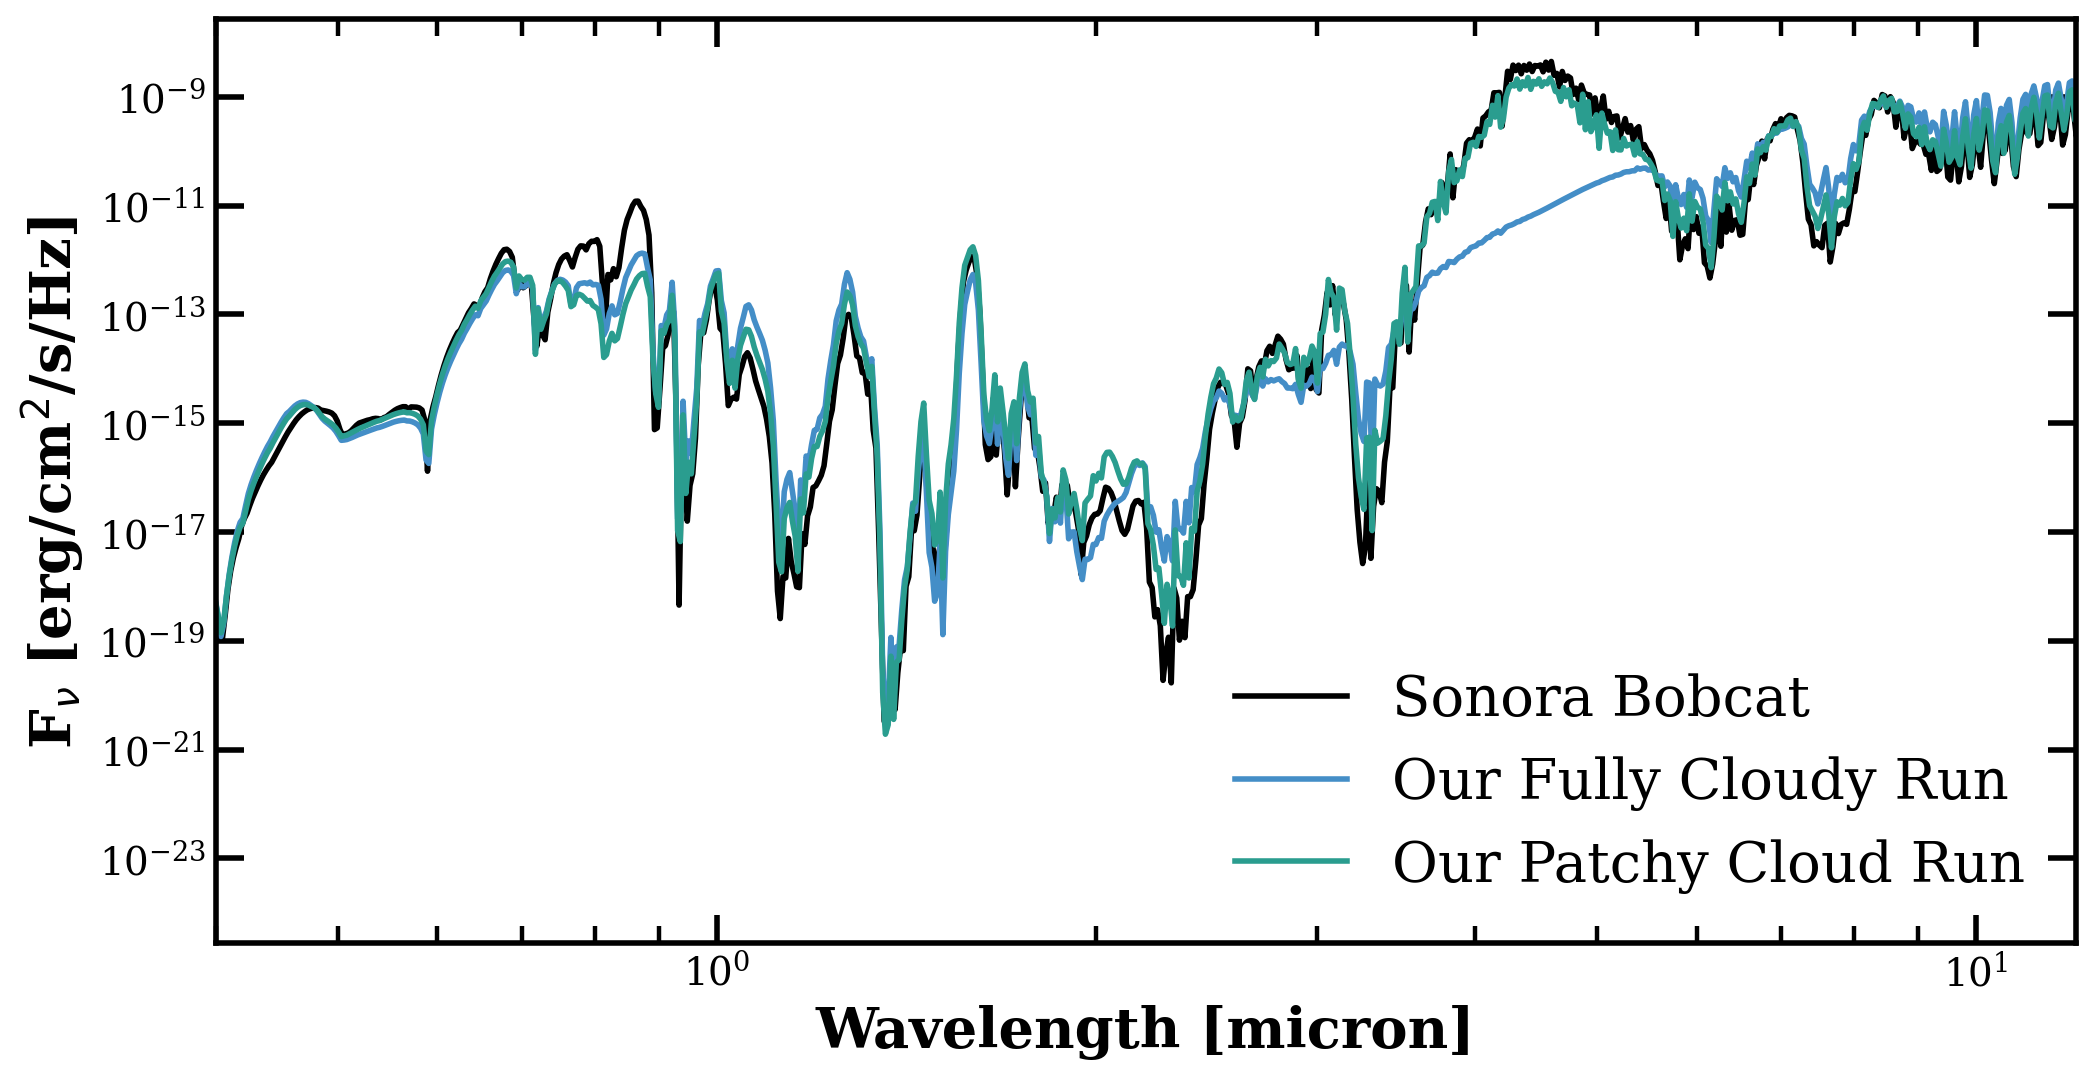

In [28]:
fig = plt.figure(figsize=(12,6))
plt.loglog(1e4/wno_bobcat,fp_bobcat, 'k', label = 'Sonora Bobcat')
plt.loglog(1e4/wno,fp, label = 'Our Fully Cloudy Run')
plt.loglog(1e4/wno_patchy,fp_patchy, label = 'Our Patchy Cloud Run')
plt.xlabel('Wavelength [micron]')
plt.ylabel('F$_\\nu$ [erg/cm$^2$/s/Hz]')
plt.xlim(0.4,12)
plt.legend()
plt.show()

In comparison to the fully cloudy model, you can see that even at 70% cloudy that the water cloud feature at 4-5 micron isn't as distinct as the 100% cloudy model. You can, however, see in the other H2O band windows that the 70% cloudy model finds itself, as we expect, between a fully clear model, and a fully cloudy model.